# Import Libraries

In [1]:
from keras.datasets import mnist 
from keras.models import Model 
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils 
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import model_from_json

import numpy as np
import json
import matplotlib.pyplot as plt
import scipy.misc

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Model Parameters

In [3]:
TESTING = True
SAVE_FILTER_JPG = False
PLOT = False   # Plot filter images?
CMAP_ON = True # CMAP on for saving files?

In [4]:
batch_size = 128     # in each iteration, we consider 32 training examples at once
kernel_size = 3      # we will use 3x3 kernels throughout
pool_size = 2        # we will use 2x2 pooling throughout
conv_depth_1 = 8     # 8 kernels in initial conv layers
conv_depth_2 = 8     # 16 kernels in later conv layers
drop_prob_1 = 0.25   # Dropout rate used for all dropout layers in variable network section
drop_prob_2 = 0.5    # Dropout rate used at end of network
hidden_size = 512    # the FC layer will have 512 neurons


total_training_epochs = 2 if TESTING else 10
fit_validation_split = 0.8 if TESTING else 0.1

In [5]:
cmap = plt.get_cmap('jet')

## Architectures

In [6]:
arch_1 = ["conv_relu", "maxpool", "dropout"]
arch_2 = ["conv_relu", "maxpool", "dropout", "conv_relu", "maxpool", "dropout"]
arch_3 = ["conv_relu", "conv_relu", "maxpool", "dropout"]

full_architectures = [arch_1, arch_2, arch_3]
TESTING_architectures = [arch_1, arch_2]

architectures = TESTING_architectures if TESTING else full_architectures

## Hyperparameters

# Load Data

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch CIFAR-10 data

depth = 1
num_train, height, width = X_train.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_test) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

### Reshape X data from (28, 28) to (28, 28, 1) for proper network feeding

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### Conv2D hyper-parameters

In [9]:
kernel_sizes = [3, 5]

# Load model

In [10]:
def load_model(model_name):
    
    # Load model architecture
    json_file = open('models/final_models/{0}/{0}_arch.json'.format(model_name, 'r'))
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
                     
    # load weights into new model
    loaded_model.load_weights("models/final_models/{0}/{0}_weights.h5".format(model_name))
    print("Loaded {} from disk.".format(model_name))

    # Compile model
    loaded_model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
                          optimizer='adam', # using the Adam optimiser
                          metrics=['accuracy']) # reporting the accuracy
    
    return loaded_model


In [11]:
loaded_models = {}
for model_id in range(4):
    model_name = "model_{}".format(model_id)
    loaded_models[model_name] = {"model" : load_model(model_name)}


Loaded model_0 from disk.
Loaded model_1 from disk.
Loaded model_2 from disk.
Loaded model_3 from disk.


## Setup Test Image for Filter Generation

In [12]:
test_images = []
label = -9999
for label_i in range(10):
    while label_i != label:
        test_image_index = np.random.randint(0, len(Y_test) - 1)
        e = Y_test[test_image_index]
        label = int(np.where(e == 1)[0])
    
    X_test_image = X_test[test_image_index]
    X_test_image = X_test_image.reshape(X_test_image.shape[0], X_test_image.shape[1])
    
    test_images.append((test_image_index, X_test_image, label))
    
    

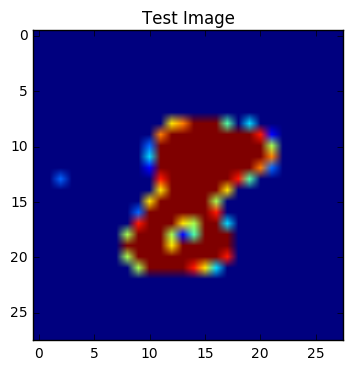

In [13]:
test_image_index = np.random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_index]
test_image = test_image.reshape(test_image.shape[0], test_image.shape[1])

# Plot image
imshow = plt.imshow
plt.title("Test Image")
imshow(test_image)

In [14]:
def generate_filter_images(model, model_name, test_image_index, test_image, label):
    
    conv_layer_num = 0
    for layer in model.layers:
        layer_name = str(layer)
        if "Conv2D" in layer_name:
            conv_layer_num += 1
            

    # Generate conv layer names for accessing layers of TensorFlow model
    conv_layer_names = ["conv_{}".format(i) for i in range(conv_layer_num)]

    
    # Iterate through conv names, accessing each conv layer
    for conv_name in conv_layer_names:
        

        # Generate model for conv layer
        conv_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(conv_name).output)

        # Predict
        conv_layer_out = conv_layer_model.predict(X_test)

        # Find convolution layer depth 
        conv_depth = conv_depth_1 if conv_name == "conv_0" else conv_depth_2
        

        # Set list of filters in current conv layer
        filters = [conv_layer_out[test_image_index,:,:,filt_id] for filt_id in range(conv_depth)]

        for filter_id, conv_filter in enumerate(filters):

            # Set filter name
            filter_name = "filter_{}".format(filter_id)

            # Set filter path
            FILTER_FILEPATH = "models/final_models/{}/conv_layers/label_{}/conv_layer_{}--filter_{}.jpg".format(model_name, label, conv_name, filter_name)

            # Determine color mapping of image save
            save_filter = cmap(conv_filter) if CMAP_ON else conv_filter

            # Write image to file
            if SAVE_FILTER_JPG:
                scipy.misc.toimage(save_filter).save(FILTER_FILEPATH)
            
            # Write as JSON
            print(save_filter.shape)
            FILTER_JSON_FILEPATH = "models/final_models/{}/conv_layers/label_{}/conv_layer_{}--filter_{}.json".format(model_name, label, conv_name, filter_name)
            with open(FILTER_FILEPATH, "w") as json_out:
                json.dump(save_filter, json_out)

            

In [15]:
for model_name, model_obj in loaded_models.items():
    current_model = model_obj["model"]
    
    for test_image_index, test_image, label in test_images:
        generate_filter_images(current_model, model_name, test_image_index, test_image, label)

(28, 28, 4)


TypeError: array([[[ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        ..., 
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ]],

       [[ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        ..., 
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ]],

       [[ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        ..., 
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ]],

       ..., 
       [[ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        ..., 
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ]],

       [[ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        ..., 
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ]],

       [[ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        ..., 
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ],
        [ 0. ,  0. ,  0.5,  1. ]]]) is not JSON serializable

<hr>


<hr>


<hr>


<hr>


<hr>


# Plot Test Image

In [ ]:
test_image_index = np.random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_index]
test_image = test_image.reshape(test_image.shape[0], test_image.shape[1])

In [ ]:
imshow = plt.imshow #alias
plt.title("Test Image")
imshow(test_image)

# Setup Hidden Layer Filters

In [ ]:
conv_depth = conv_depth_1 if (layer_name == "conv_0" or layer_name == "conv_1") else conv_depth_2
filters = [new_model_out[test_image_index,:,:,filt_id] for filt_id in range(conv_depth)]

# Show Filters

In [ ]:
fig = plt.figure()

for i in range(conv_depth):
    filter_num = i+1
    ax = plt.subplot(conv_depth//4+1, 4, filter_num)
    
    imshow = plt.imshow #alias
    imshow(filters[i])
#     imshow(filters[i], cmap=plt.get_cmap('gray'))
    
    ax.set_title("Filter: {}".format(filter_num))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.set_figwidth(20)
fig.set_figheight(20)

<hr>


<hr>


<hr>


<hr>


# References

https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer




https://github.com/fchollet/keras/issues/431

http://stackoverflow.com/questions/36745821/keras-1-0-getting-intermediate-layer-output/36789699#36789699

https://github.com/fchollet/keras/issues/2417

http://stackoverflow.com/questions/41911883/typeerror-tensor-object-is-not-callable